# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
- [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
- [Time-series plots of infections in most infected countries](#time-series_countries)
- [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
- [Relative increases per day by country](#country_relative_increases)
- [Time-series plots of mortality](#time-series_country_mortality)
- [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
  - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
- [Density of infections per million people](#density_of_infections_by_country)
- [How many days behind is each country from Italy?](#days_behind)
- [US states with the most new infections](#states_most_infections)
- [Time-series plots of infections in most-infected states](#time-series_states)
- [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
- [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
- [Compare US state infections against Washington](#state_infections_vs_wa)
- [Compare US state infections against New York](#state_infections_vs_ny)
- [Mortality rate by US state](#mortality_by_us_state)
- [Relative increases per day by state](#us_state_relative_increases)
- [When will each US state hit 1 case?](#us_state_0_new)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [56]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [136]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [137]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [138]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-04-30 20:48:39.986015
metric: deaths at 2020-04-30 20:48:41.147753
Latest data from 2020-04-30


In [139]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [140]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

,date,country,confirmed,confirmed_new,deaths,deaths_new,mortality_rate
0,2020-04-30,US,1069424,29515,62996,2029,0.058906
1,2020-04-30,Italy,205463,1872,27967,285,0.136117
2,2020-04-30,United Kingdom,172481,6040,26842,676,0.155623
3,2020-04-30,Spain,213435,518,24543,268,0.114991
4,2020-04-30,France,167299,756,24410,289,0.145906
5,2020-04-30,Belgium,48519,660,7594,93,0.156516
6,2020-04-30,Germany,163009,1470,6623,156,0.040630
7,2020-04-30,Iran,94640,983,6028,71,0.063694
8,2020-04-30,Brazil,87187,7502,6006,493,0.068886
9,2020-04-30,Netherlands,39512,514,4811,84,0.121760


<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [141]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

,date,country,confirmed,confirmed_new,deaths,deaths_new,mortality_rate
0,2020-04-30,US,1069424,29515,62996,2029,0.058906
8,2020-04-30,Brazil,87187,7502,6006,493,0.068886
18,2020-04-30,Russia,106498,7099,1073,101,0.010075
2,2020-04-30,United Kingdom,172481,6040,26842,676,0.155623
19,2020-04-30,Peru,36976,3045,1051,108,0.028424
12,2020-04-30,Turkey,120204,2615,3174,93,0.026405
44,2020-04-30,Serbia,9009,2379,179,54,0.019869
1,2020-04-30,Italy,205463,1872,27967,285,0.136117
17,2020-04-30,India,34863,1801,1154,75,0.033101
11,2020-04-30,Canada,54457,1592,3310,155,0.060782


<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [142]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

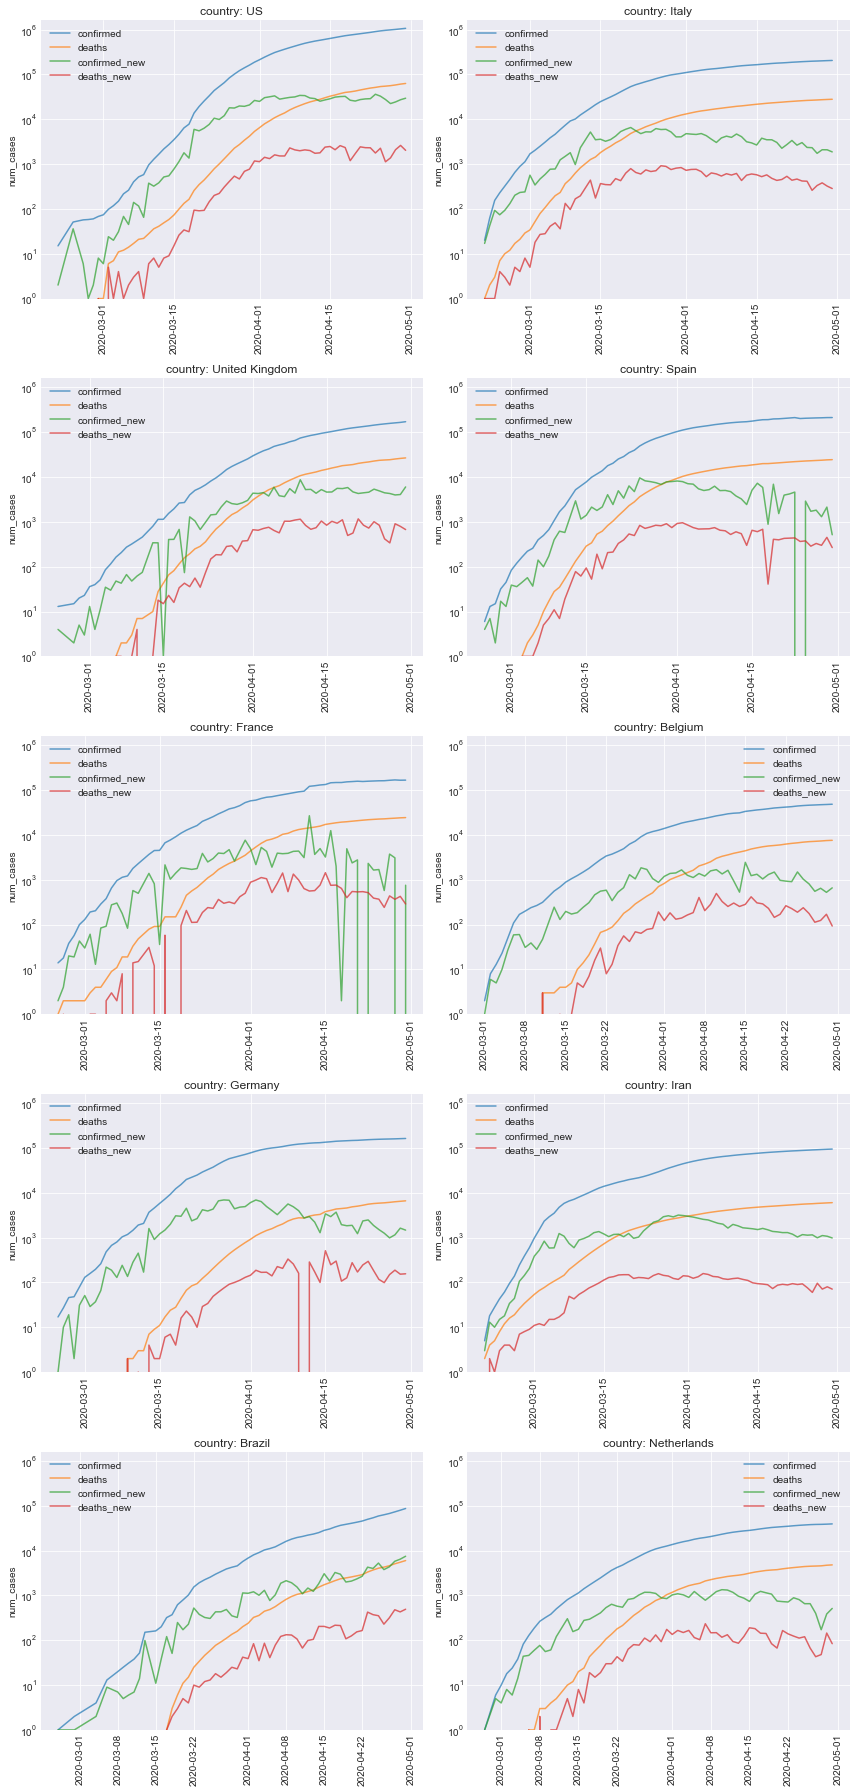

In [143]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

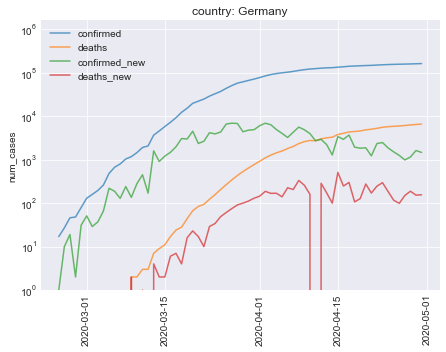

In [144]:
plot_countries(dfp_country, 
               countries=['Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [145]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    for col in ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-05-01 2020-05-07 2020-05-21  2020-05-01 2020-05-07   
country                                                                      
US                  1099141.0  1291578.0  1881964.0     64798.0    78886.0   
Italy                207807.0   221114.0   255571.0     28352.0    30527.0   
United Kingdom       177001.0   209851.0   312192.0     27478.0    32141.0   
Spain                216045.0   227082.0   255077.0     24916.0    27151.0   
France               170275.0   179096.0   201497.0     24821.0    27243.0   
Belgium               49367.0    53876.0    66063.0      7803.0     8836.0   
Germany              164165.0   172379.0   193181.0      6769.0     7807.0   
Brazil                93191.0   148486.0   440296.0      6452.0    10414.0   
Iran                  95858.0   102865.0   121273.0      6112.0     6616.0   
Netherlands           40015.0    42842.0    50239.0      4878.0     5414.0   

                          mortality_rate_pred                        \
date           2020-05-21          2020-05-01 2020-05-07 2020-05-21   
country                                                               
US               124840.0            0.058953   0.061077   0.066335   
Italy             36272.0            0.136434   0.138060   0.141925   
United Kingdom    46334.0            0.155242   0.153161   0.148415   
Spain             33177.0            0.115328   0.119565   0.130067   
France            33856.0            0.145770   0.152114   0.168022   
Belgium           11809.0            0.158061   0.164006   0.178754   
Germany           10887.0            0.041233   0.045290   0.056356   
Brazil            31822.0            0.069234   0.070135   0.072274   
Iran               7959.0            0.063761   0.064317   0.065629   
Netherlands        6905.0            0.121904   0.126371   0.137443   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.027254             0.033331  
Italy                         0.010398             0.012394  
United Kingdom                0.028779             0.026469  
Spain                         0.008338             0.014420  
France                        0.008453             0.015642  
Belgium                       0.014673             0.020935  
Germany                       0.008171             0.024041  
Brazil                        0.080733             0.083052  
Iran                          0.011828             0.013286  
Netherlands                   0.011443             0.017532

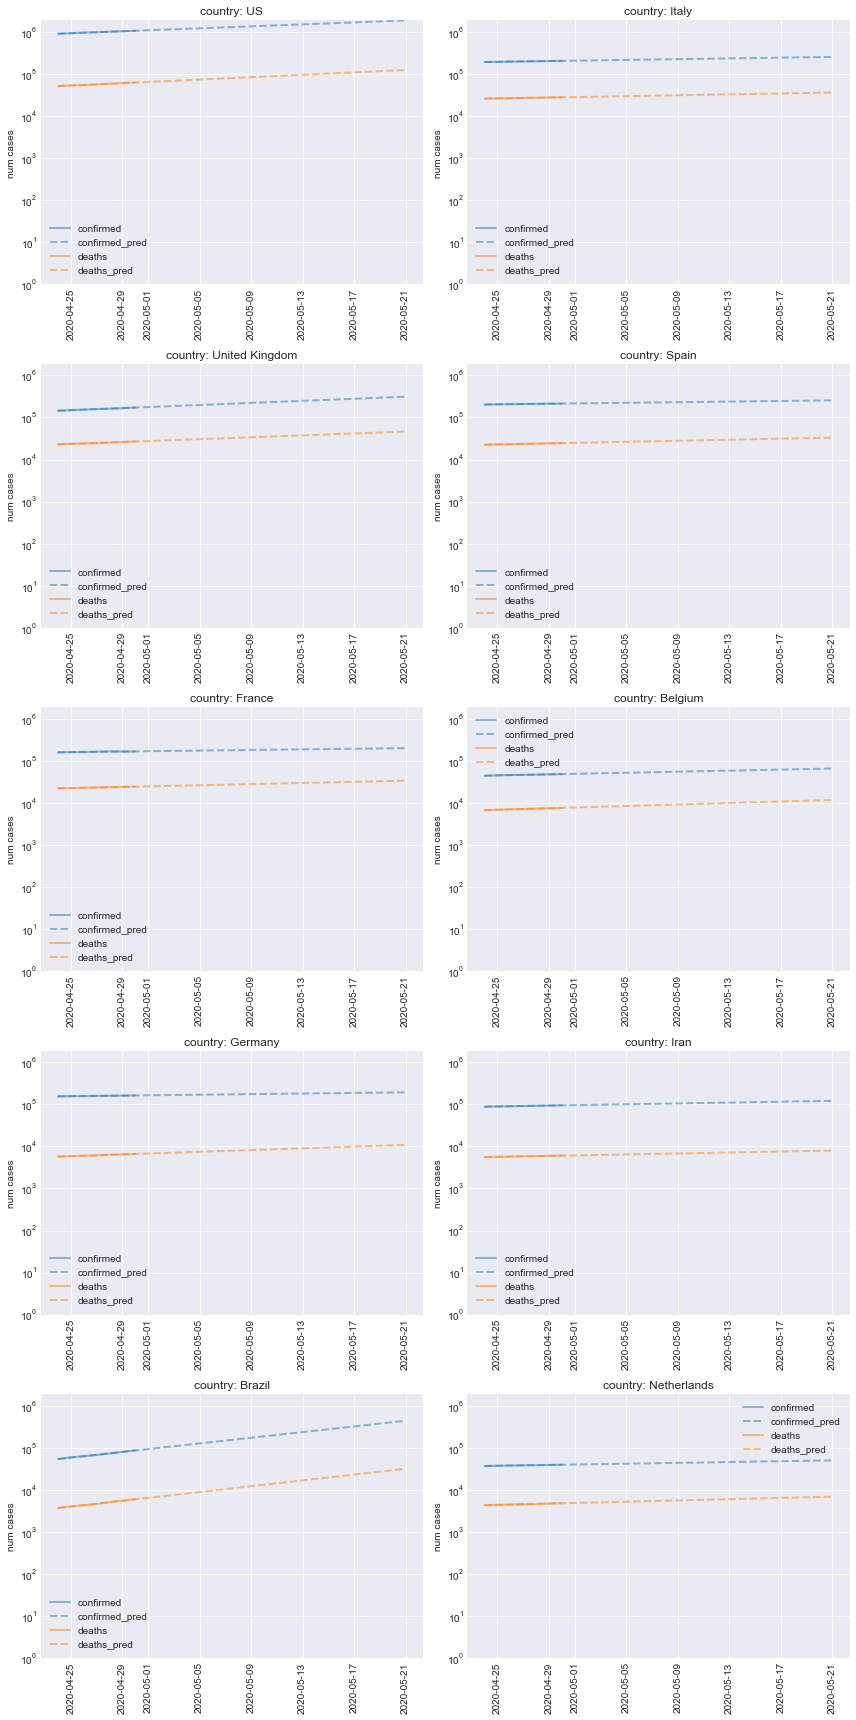

In [146]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [147]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-04-30_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [148]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


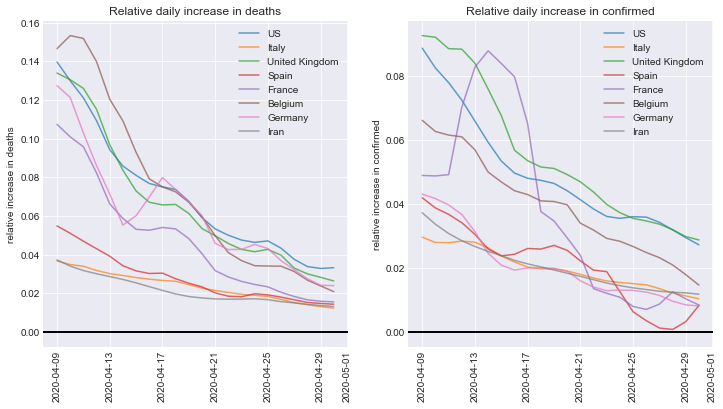

In [149]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-05-01 2020-05-07  2020-05-01 2020-05-07   
country                                                           
US                  1122685.0  1365125.0     66584.0    84421.0   
Italy                210324.0   228009.0     28766.0    31659.0   
United Kingdom       180838.0   221402.0     28439.0    35087.0   
France               171326.0   181752.0     25301.0    28553.0   
Spain                216895.0   227008.0     25139.0    27785.0   
Belgium               50970.0    58476.0      8075.0     9645.0   
Germany              165959.0   177283.0      7034.0     8602.0   
Brazil                90999.0   140519.0      6417.0    10408.0   
Iran                  96464.0   104463.0      6161.0     6751.0   
Netherlands           41247.0    46264.0      5024.0     5837.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-05-01 2020-05-07                           
country                                                                 
US                        0.059308   0.061841                0.033124   
Italy                     0.136770   0.138850                0.013548   
United Kingdom            0.157262   0.158476                0.034306   
France                    0.147678   0.157099                0.009895   
Spain                     0.115904   0.122397                0.007625   
Belgium                   0.158427   0.164939                0.023160   
Germany                   0.042384   0.048521                0.011062   
Brazil                    0.070517   0.074068                0.075102   
Iran                      0.063868   0.064626                0.013366   
Netherlands               0.121803   0.126167                0.019317   

               frac_increase_deaths  
date                                 
country                              
US                         0.040351  
Italy                      0.016099  
United Kingdom             0.035630  
France                     0.020357  
Spain                      0.016816  
Belgium                    0.030043  
Germany                    0.034101  
Brazil                     0.083931  
Iran                       0.015360  
Netherlands                0.025329

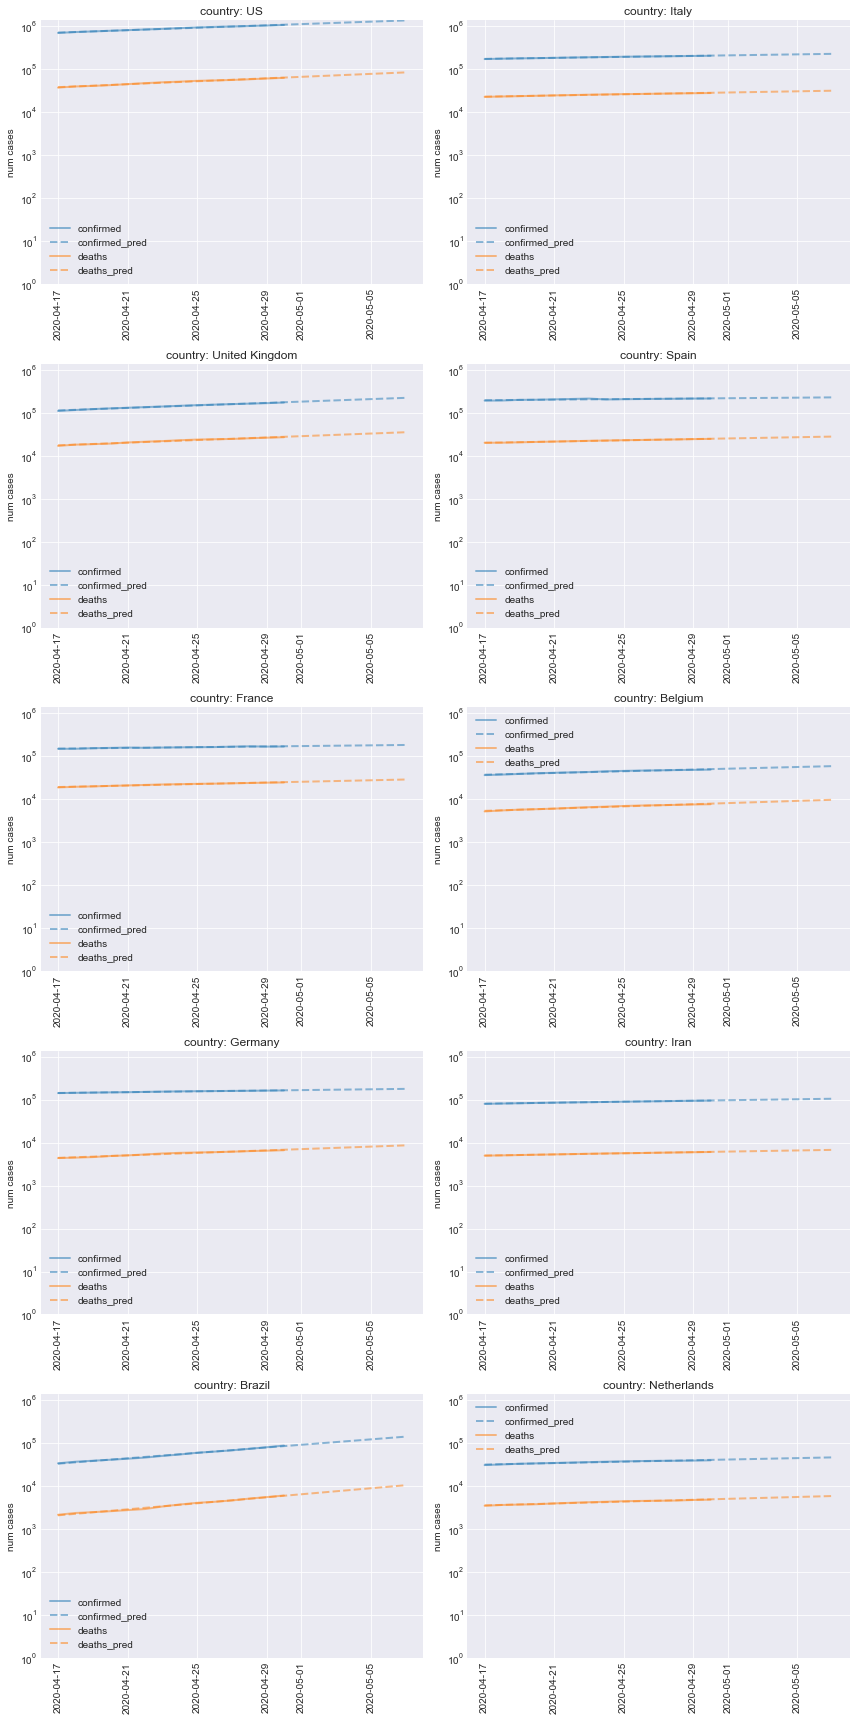

In [150]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [151]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-04-30_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [152]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

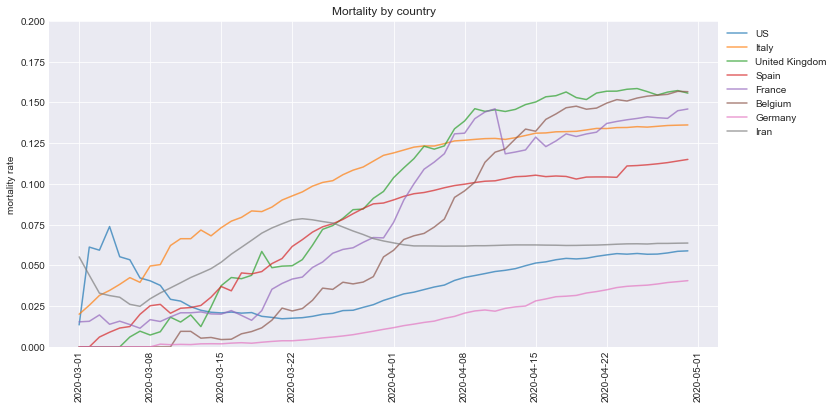

In [153]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [154]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

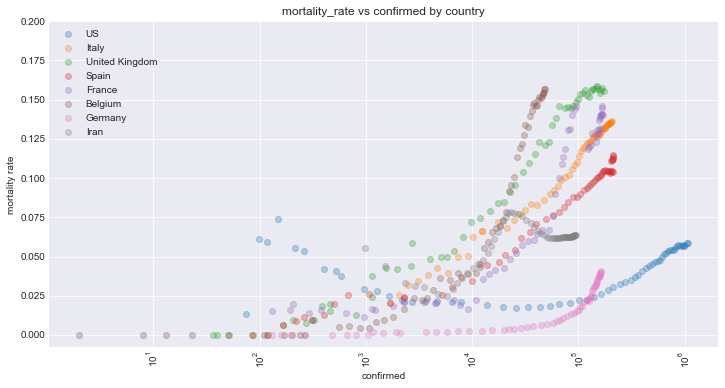

In [155]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [156]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

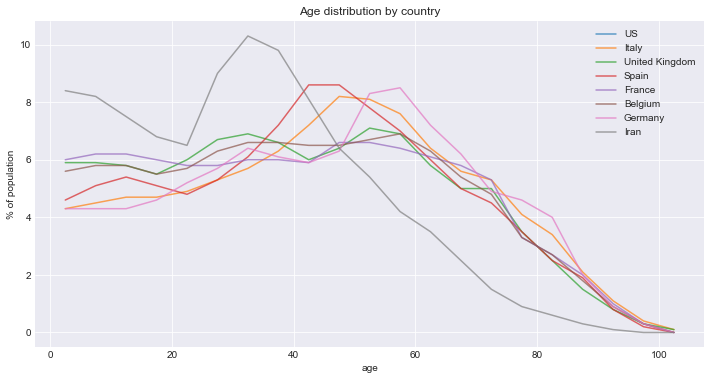

In [157]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

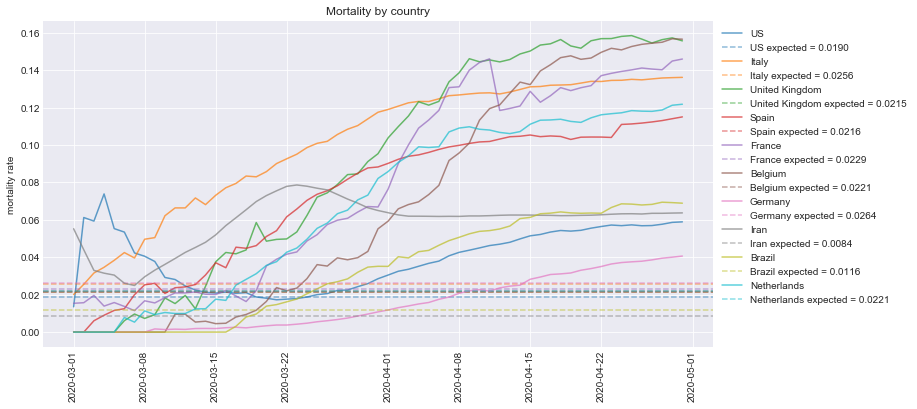

,date,country,mortality_rate,confirmed,deaths
0,2020-04-30,Belgium,0.156516,48519.0,7594.0
1,2020-04-30,United Kingdom,0.155623,172481.0,26842.0
2,2020-04-30,France,0.145906,167299.0,24410.0
3,2020-04-30,Italy,0.136117,205463.0,27967.0
4,2020-04-30,Netherlands,0.121760,39512.0,4811.0
5,2020-04-30,Spain,0.114991,213435.0,24543.0
6,2020-04-30,Brazil,0.068886,87187.0,6006.0
7,2020-04-30,Iran,0.063694,94640.0,6028.0
8,2020-04-30,US,0.058906,1069424.0,62996.0
9,2020-04-30,Germany,0.040630,163009.0,6623.0


In [158]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

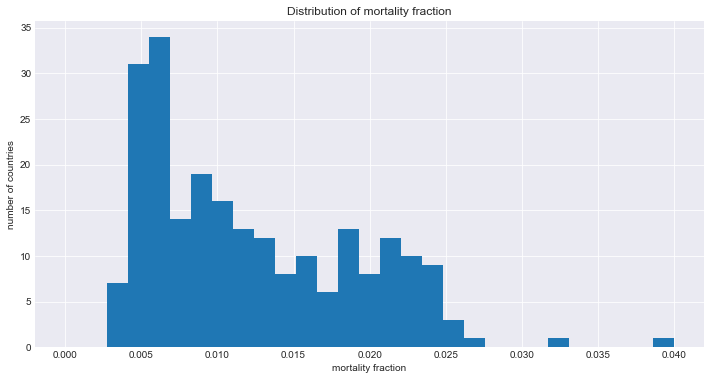

In [159]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [160]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

,country,frac_mortality,num_deaths_max_expected,pop
1,Japan,0.031837,3998380.024,125507472
2,Germany,0.026398,2128411.026,80159662
3,Greece,0.025745,271233.247,10607051
4,Italy,0.025637,1599267.592,62402659
10,Portugal,0.023736,244829.259,10302674
18,France,0.022950,1564984.503,67848156
20,Sweden,0.022575,231555.716,10202491
23,Belgium,0.022146,259573.363,11720716
24,Netherlands,0.022076,382222.125,17280397
27,Canada,0.021712,820035.480,37694085


<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [161]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

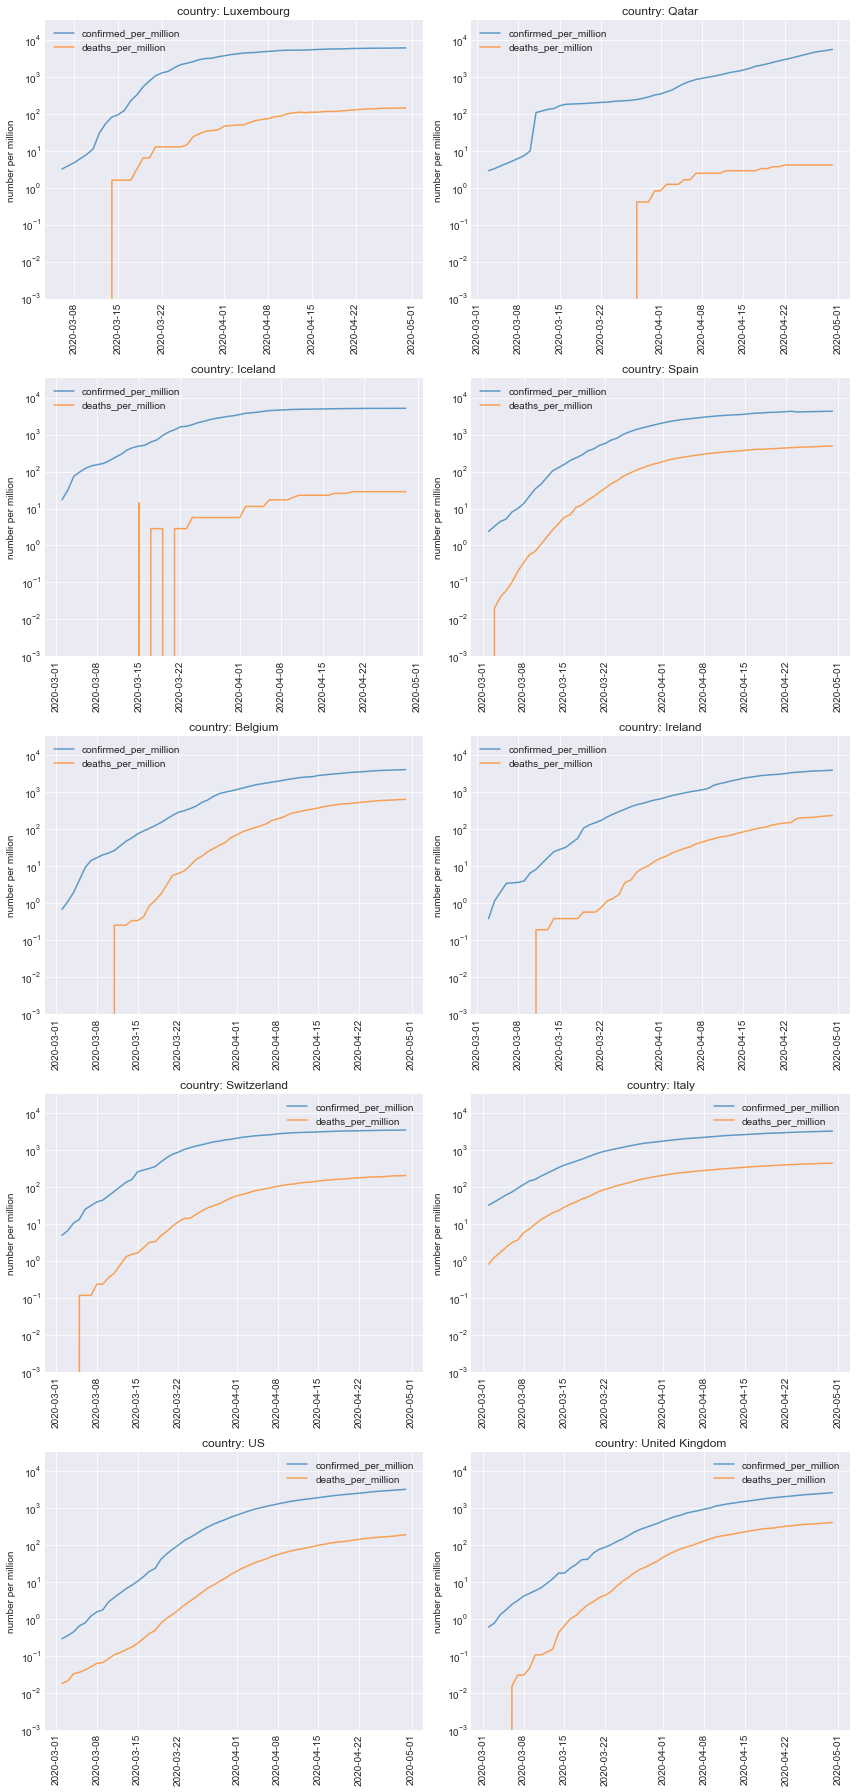

,country,population,confirmed,deaths,confirmed_per_million,deaths_per_million,mortality_rate
0,Luxembourg,628381.0,3784.0,90.0,6021.824339,143.225209,0.023784
1,Qatar,2444174.0,13409.0,10.0,5486.106963,4.091362,0.000746
2,Iceland,350734.0,1797.0,10.0,5123.540917,28.511636,0.005565
3,Spain,50015792.0,213435.0,24543.0,4267.352199,490.705016,0.114991
4,Belgium,11720716.0,48519.0,7594.0,4139.593520,647.912636,0.156516
5,Ireland,5176569.0,20612.0,1232.0,3981.787937,237.995475,0.059771
6,Switzerland,8403994.0,29586.0,1737.0,3520.468958,206.687439,0.058710
7,Italy,62402659.0,205463.0,27967.0,3292.535980,448.170005,0.136117
8,US,332639102.0,1069424.0,62996.0,3214.967794,189.382426,0.058906
9,United Kingdom,65761117.0,172481.0,26842.0,2622.841701,408.174332,0.155623


In [162]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

### Mortality rate by deaths per capita, confirmed per capita

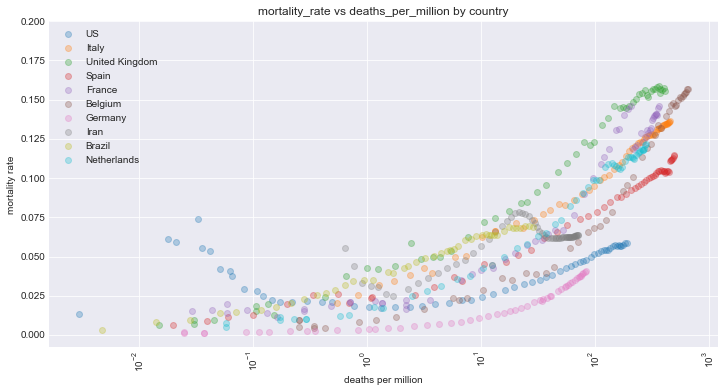

In [163]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

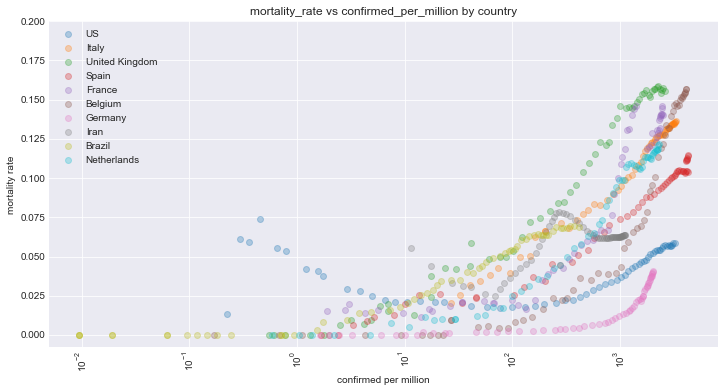

In [164]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [165]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

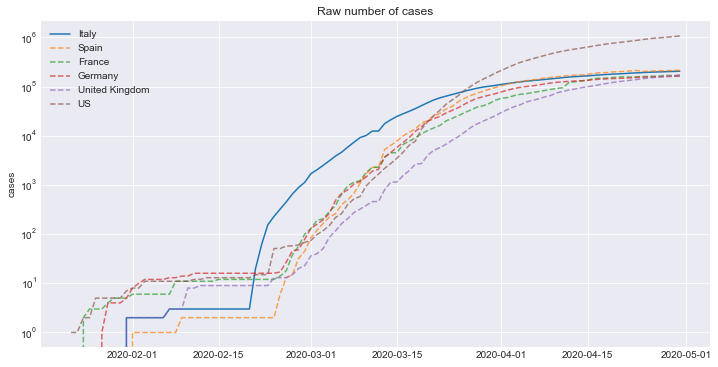

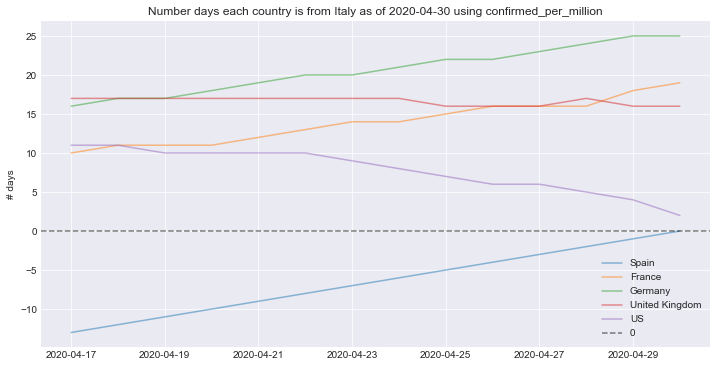

In [166]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

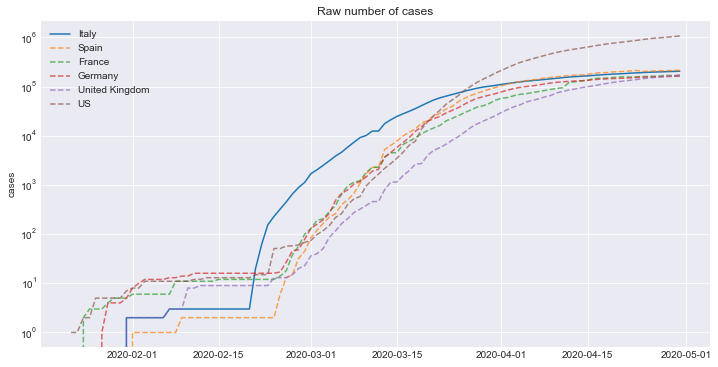

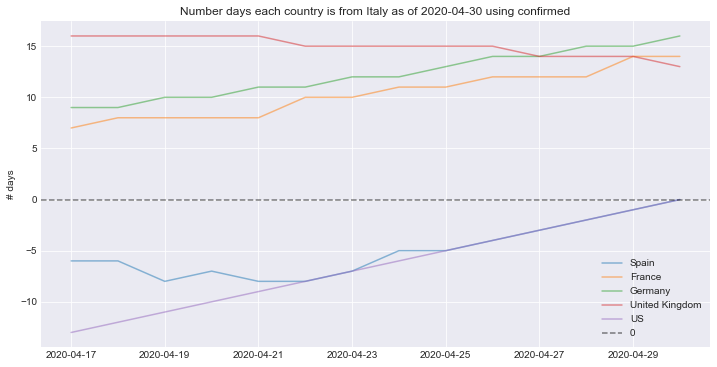

In [167]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [168]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [169]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [170]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [171]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [172]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

,date,state,confirmed,confirmed_new,deaths,deaths_new,mortality_rate
0,2020-05-01,New York,304372,4681,23587,110,0.077494
1,2020-05-01,New Jersey,118652,2287,7228,457,0.060918
2,2020-05-01,Michigan,41379,980,3789,119,0.091568
3,2020-05-01,Massachusetts,62205,1940,3562,157,0.057262
4,2020-05-01,Pennsylvania,47971,1644,2475,102,0.051594
5,2020-05-01,Illinois,52918,2560,2355,140,0.044503
6,2020-05-01,Connecticut,27700,933,2257,88,0.081480
7,2020-05-01,California,50130,1383,2031,85,0.040515
8,2020-05-01,Louisiana,28001,341,1905,60,0.068033
9,2020-05-01,Florida,33690,497,1268,50,0.037637


<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [173]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

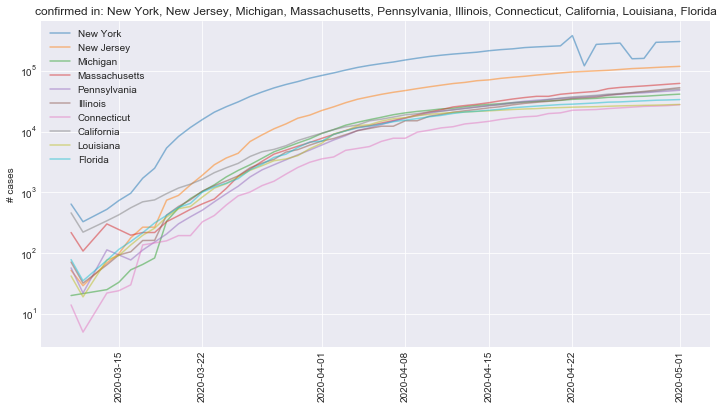

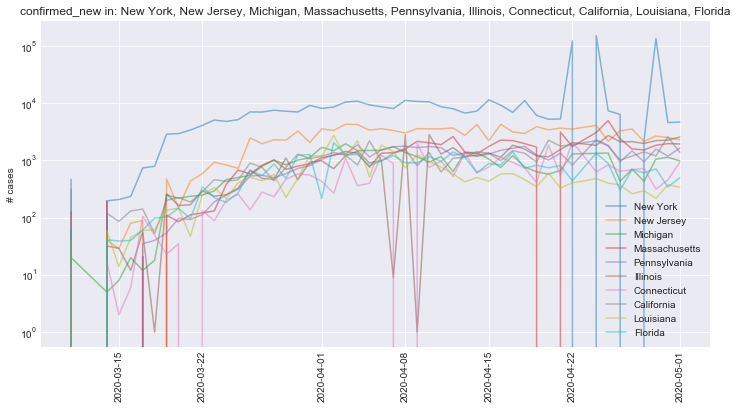

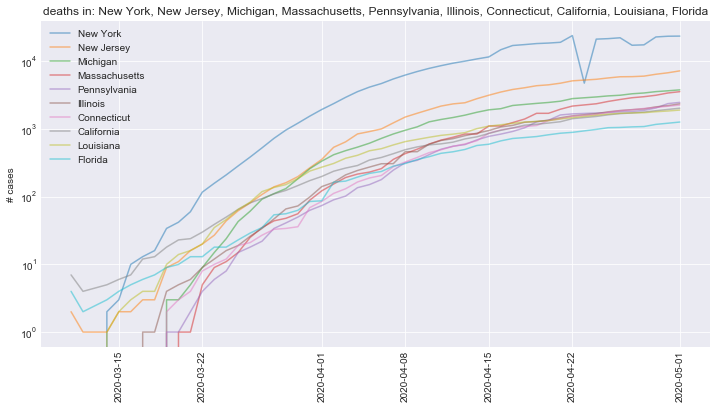

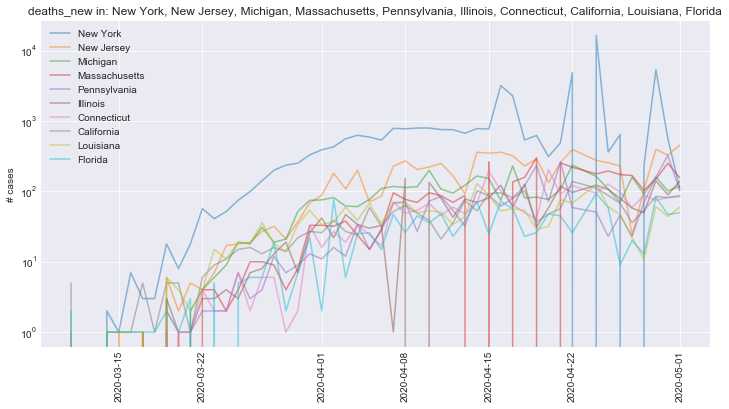

In [174]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

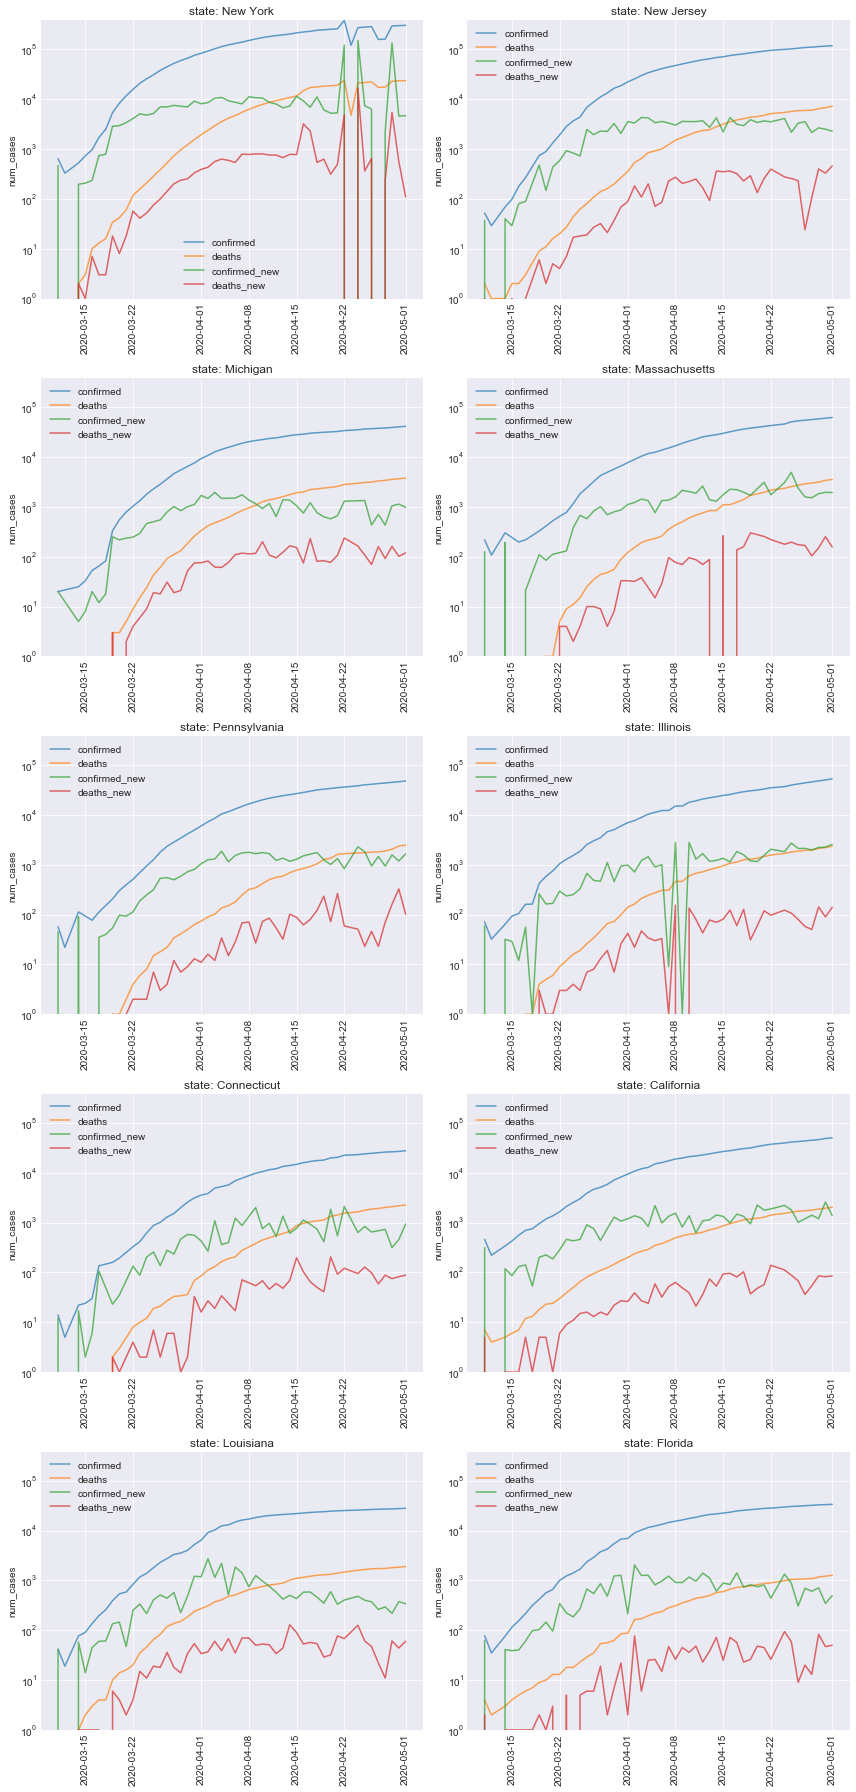

In [175]:
plot_countries(dfp_us_g, 
               countries=dfp_us_top_states.iloc[:10]['state'].values,
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

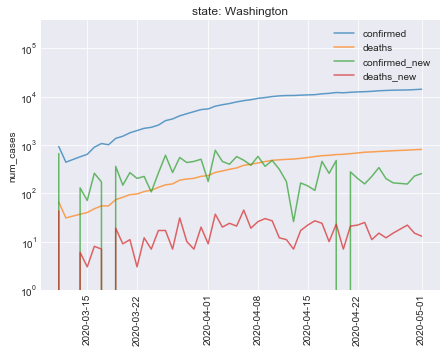

In [176]:
plot_countries(dfp_us_g, 
               countries=['Washington'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

confirmed_pred                       deaths_pred             \
date              2020-05-02 2020-05-08 2020-05-22  2020-05-02 2020-05-08   
state                                                                       
New York            282451.0   346956.0   560679.0     23120.0    26552.0   
New Jersey          122269.0   141668.0   199757.0      7307.0     9197.0   
Michigan             41953.0    47455.0    63266.0      3939.0     4872.0   
Massachusetts        64287.0    77977.0   122348.0      3760.0     5210.0   
Pennsylvania         49244.0    58753.0    88705.0      2561.0     3706.0   
Illinois             55480.0    73781.0   143489.0      2426.0     3166.0   
Connecticut          28269.0    32486.0    44935.0      2352.0     2988.0   
California           51550.0    62728.0    99163.0      2090.0     2611.0   
Louisiana            28281.0    30224.0    35293.0      1928.0     2197.0   
Florida              34384.0    38135.0    48557.0      1292.0     1584.0   

                         mortality_rate_pred                        \
date          2020-05-22          2020-05-02 2020-05-08 2020-05-22   
state                                                                
New York         36676.0            0.081855   0.076528   0.065414   
New Jersey       15732.0            0.059762   0.064919   0.078756   
Michigan          8004.0            0.093891   0.102666   0.126513   
Massachusetts    11149.0            0.058488   0.066815   0.091125   
Pennsylvania      8780.0            0.052006   0.063078   0.098980   
Illinois          5894.0            0.043727   0.042911   0.041076   
Connecticut       5226.0            0.083201   0.091978   0.116301   
California        4385.0            0.040543   0.041624   0.044220   
Louisiana         2980.0            0.068173   0.072691   0.084436   
Florida           2548.0            0.037576   0.041537   0.052474   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.034876             0.023340  
New Jersey                   0.024847             0.039086  
Michigan                     0.020753             0.036086  
Massachusetts                0.032699             0.055843  
Pennsylvania                 0.029863             0.063537  
Illinois                     0.048658             0.045378  
Connecticut                  0.023443             0.040721  
California                   0.033251             0.037739  
Louisiana                    0.011136             0.021998  
Florida                      0.017406             0.034521

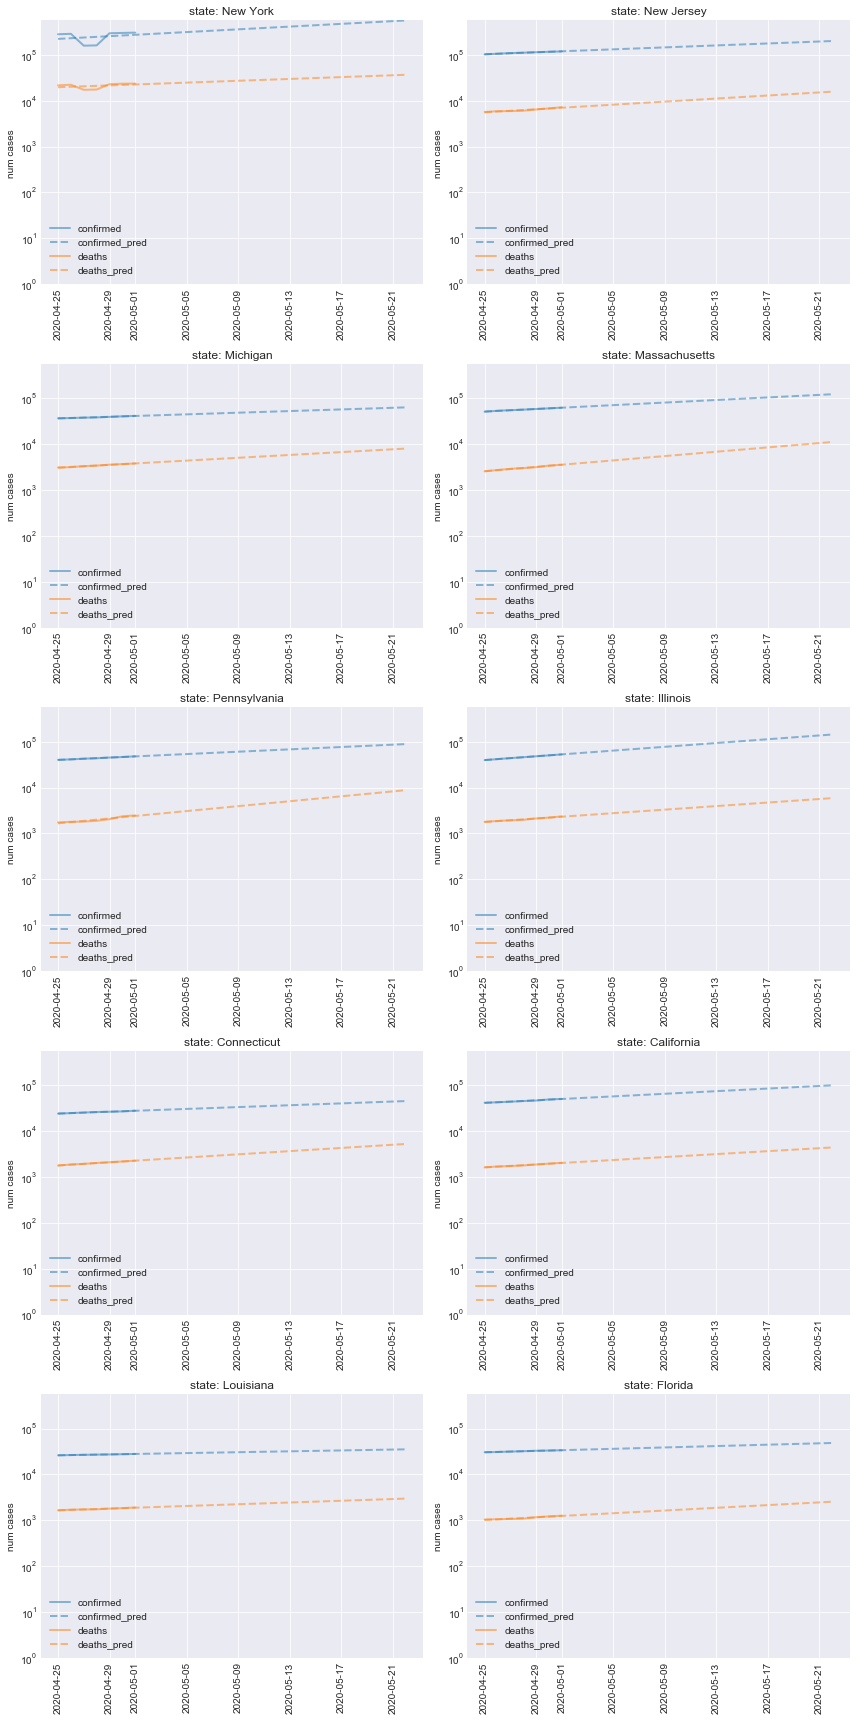

In [177]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

##### 2 weeks of data

confirmed_pred                       deaths_pred             \
date              2020-05-02 2020-05-08 2020-05-22  2020-05-02 2020-05-08   
state                                                                       
New York            249895.0   254407.0   265256.0     21994.0    25347.0   
New Jersey          124157.0   146959.0   217797.0      7389.0     9418.0   
Michigan             42281.0    48453.0    66585.0      3995.0     5040.0   
Massachusetts        66806.0    86860.0   160265.0      3958.0     5910.0   
Pennsylvania         49626.0    60000.0    93436.0      2514.0     3438.0   
Connecticut          29586.0    36332.0    58671.0      2498.0     3473.0   
Illinois             55101.0    72703.0   138824.0      2463.0     3286.0   
California           52576.0    65755.0   110810.0      2158.0     2832.0   
Louisiana            28479.0    30752.0    36788.0      2006.0     2434.0   
Florida              34924.0    39686.0    53476.0      1322.0     1676.0   

                         mortality_rate_pred                        \
date          2020-05-22          2020-05-02 2020-05-08 2020-05-22   
state                                                                
New York         35296.0            0.088013   0.099632   0.133064   
New Jersey       16593.0            0.059513   0.064086   0.076186   
Michigan          8671.0            0.094487   0.104018   0.130225   
Massachusetts    15064.0            0.059246   0.068041   0.093994   
Pennsylvania      7137.0            0.050659   0.057300   0.076384   
Connecticut       7486.0            0.084432   0.095591   0.127593   
Illinois          6444.0            0.044700   0.045198   0.046418   
California        5343.0            0.041045   0.043069   0.048218   
Louisiana         3820.0            0.070438   0.079149   0.103838   
Florida           2917.0            0.037854   0.042232   0.054548   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.002987             0.023932  
New Jersey                   0.028499             0.041278  
Michigan                     0.022966             0.039506  
Massachusetts                0.044723             0.069110  
Pennsylvania                 0.032144             0.053546  
Connecticut                  0.034824             0.056397  
Illinois                     0.047285             0.049262  
California                   0.037981             0.046369  
Louisiana                    0.012882             0.032718  
Florida                      0.021531             0.040350

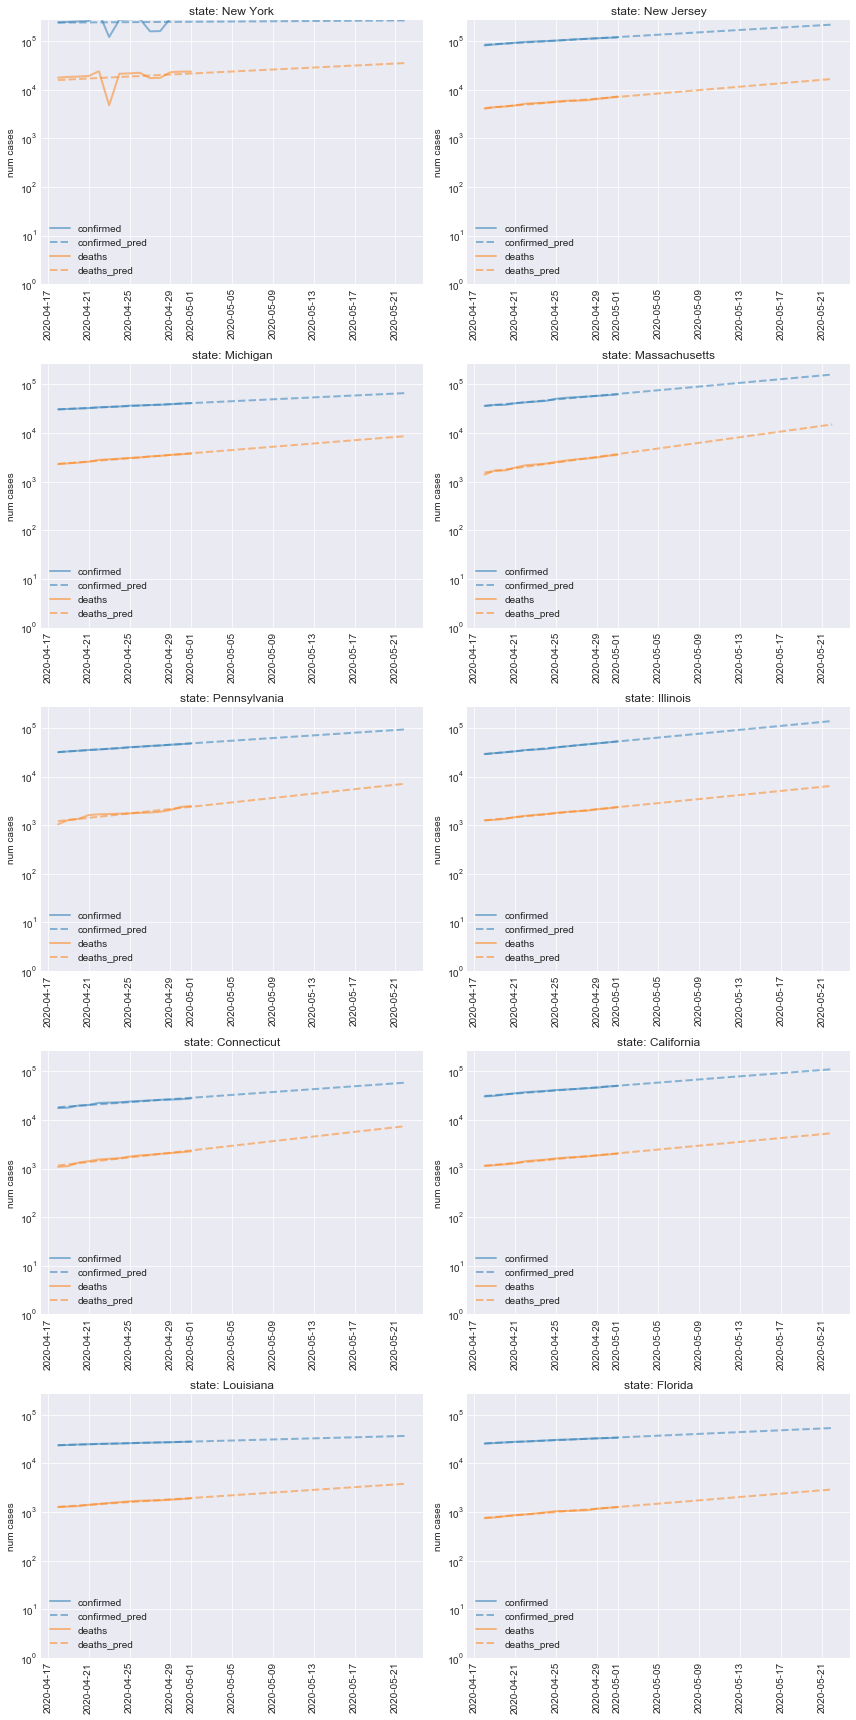

In [178]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [179]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [180]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


,date,state,confirmed,deaths,deaths_new,frac_increase_confirmed,frac_increase_deaths
0,2020-05-01,South Dakota,2449,17,4,0.029,0.079
1,2020-05-01,South Carolina,6095,244,13,0.030,0.077
2,2020-05-01,Minnesota,5136,343,24,0.081,0.072
3,2020-05-01,Iowa,7145,162,14,0.080,0.072
4,2020-05-01,Delaware,4734,152,8,0.059,0.070
5,2020-05-01,Pennsylvania,47971,2475,102,0.030,0.064
6,2020-05-01,Indiana,17835,1114,150,0.046,0.064
7,2020-05-01,Ohio,18027,976,39,0.028,0.062
8,2020-05-01,District of Columbia,4323,224,19,0.031,0.060
9,2020-05-01,Maryland,21742,1140,62,0.044,0.059


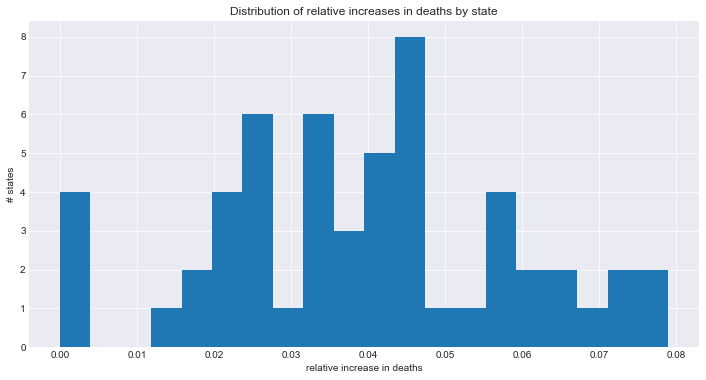

In [181]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

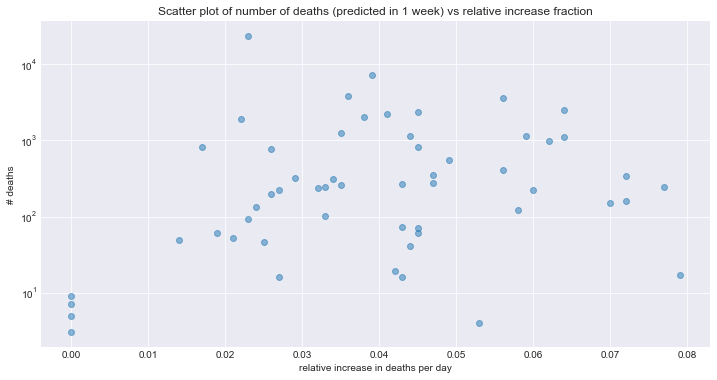

In [182]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [183]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

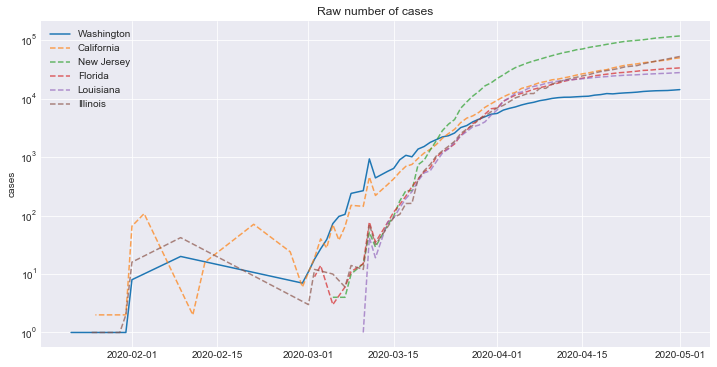

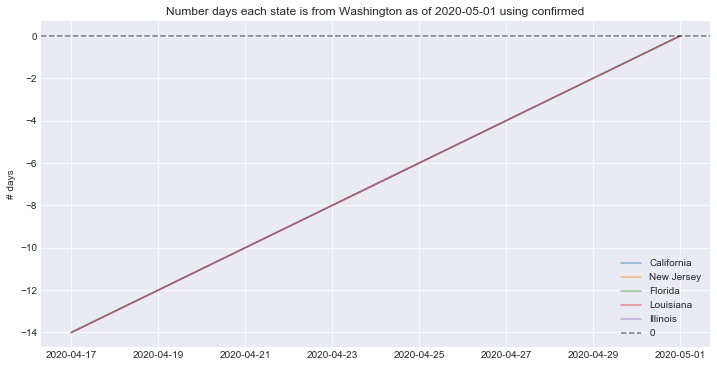

In [184]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

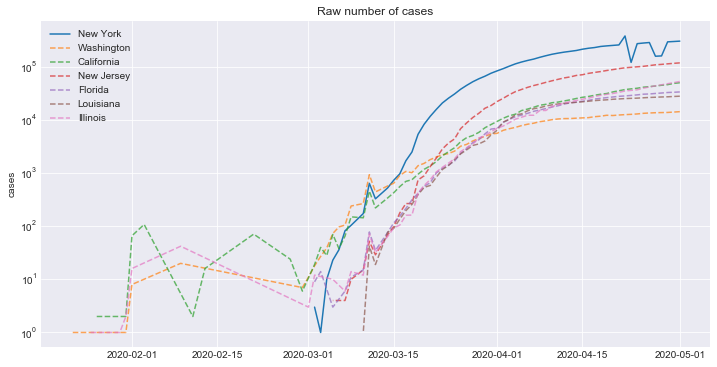

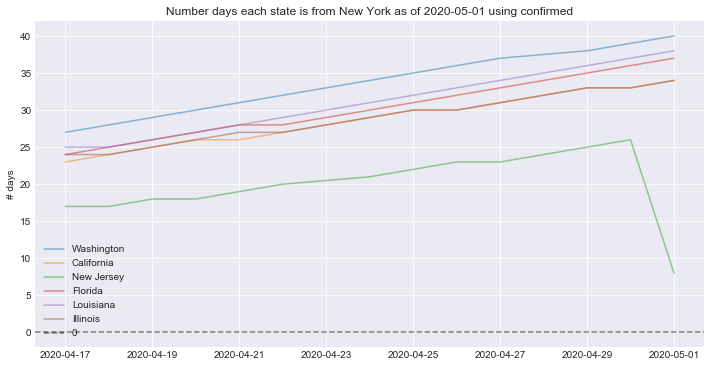

In [185]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

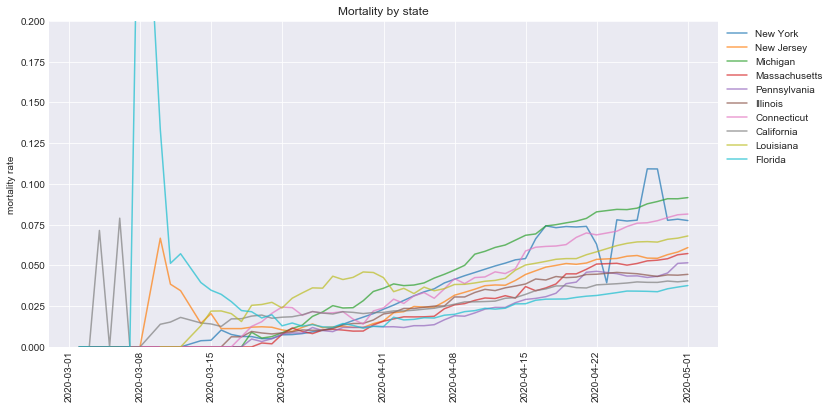

In [186]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

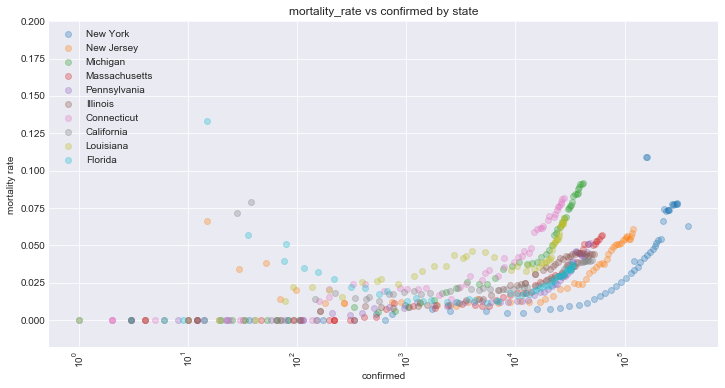

In [187]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

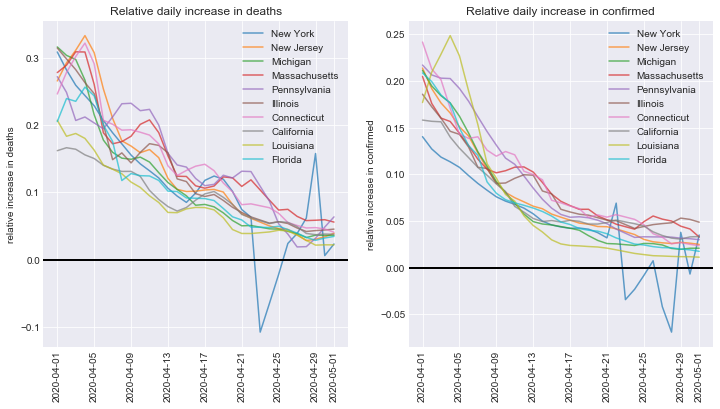

In [188]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [189]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [190]:
n_days_training = 28
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )

confirmed_new_pred                                              \
date                  2020-05-02 2020-05-08 2020-05-15 2020-05-29 2020-06-26   
state                                                                          
New York                   11592      12234      13028      14773      18995   
Illinois                    2831       3804       5368      10692      42411   
New Jersey                  2708       2522       2322       1968       1414   
Massachusetts               2474       2774       3171       4144       7076   
California                  1660       1815       2014       2480       3759   
Pennsylvania                1271       1216       1154       1040        844   
Michigan                     706        615        524        379        199   
Connecticut                  702        676        646        592        496   
Florida                      524        438        356        235        102   
Louisiana                    235        167        112         50         10   

                                                                      \
date          2020-07-24 2020-08-21 2020-09-18 2020-10-16 2020-12-11   
state                                                                  
New York           24424      31406      40382      51925      85850   
Illinois          168225     667272    2646755   10498429  165175435   
New Jersey          1016        730        524        376        194   
Massachusetts      12083      20631      35228      60151     175371   
California          5699       8640      13098      19856      45631   
Pennsylvania         685        556        452        367        241   
Michigan             104         55         28         15          4   
Connecticut          416        349        292        245        172   
Florida               44         19          8          3          0   
Louisiana              2          0          0          0          0   

              deaths_new_pred                                              \
date               2020-05-02 2020-05-08 2020-05-15 2020-05-29 2020-06-26   
state                                                                       
New York                  847        854        862        879        914   
Illinois                  106        121        141        193        361   
New Jersey                253        273        299        358        514   
Massachusetts             294        431        673       1639       9722   
California                 89        105        128        189        413   
Pennsylvania              111        138        178        294        804   
Michigan                  126        131        137        150        180   
Connecticut               119        149        195        333        965   
Florida                    39         40         43         47         59   
Louisiana                  43         41         38         33         24   

                                                                      \
date          2020-07-24 2020-08-21 2020-09-18 2020-10-16 2020-12-11   
state                                                                  
New York             951        988       1028       1069       1155   
Illinois             674       1258       2347       4378      15238   
New Jersey           738       1059       1520       2181       4493   
Massachusetts      57664     342007    2028426   12030477  423184694   
California           903       1974       4315       9428      45014   
Pennsylvania        2198       6006      16409      44825     334515   
Michigan             216        259        311        373        536   
Connecticut         2800       8117      23534      68227     573426   
Florida               72         89        110        136        207   
Louisiana             18         14         10          7          4   

              frac_increase_confirmed frac_increase_deaths  
date                                

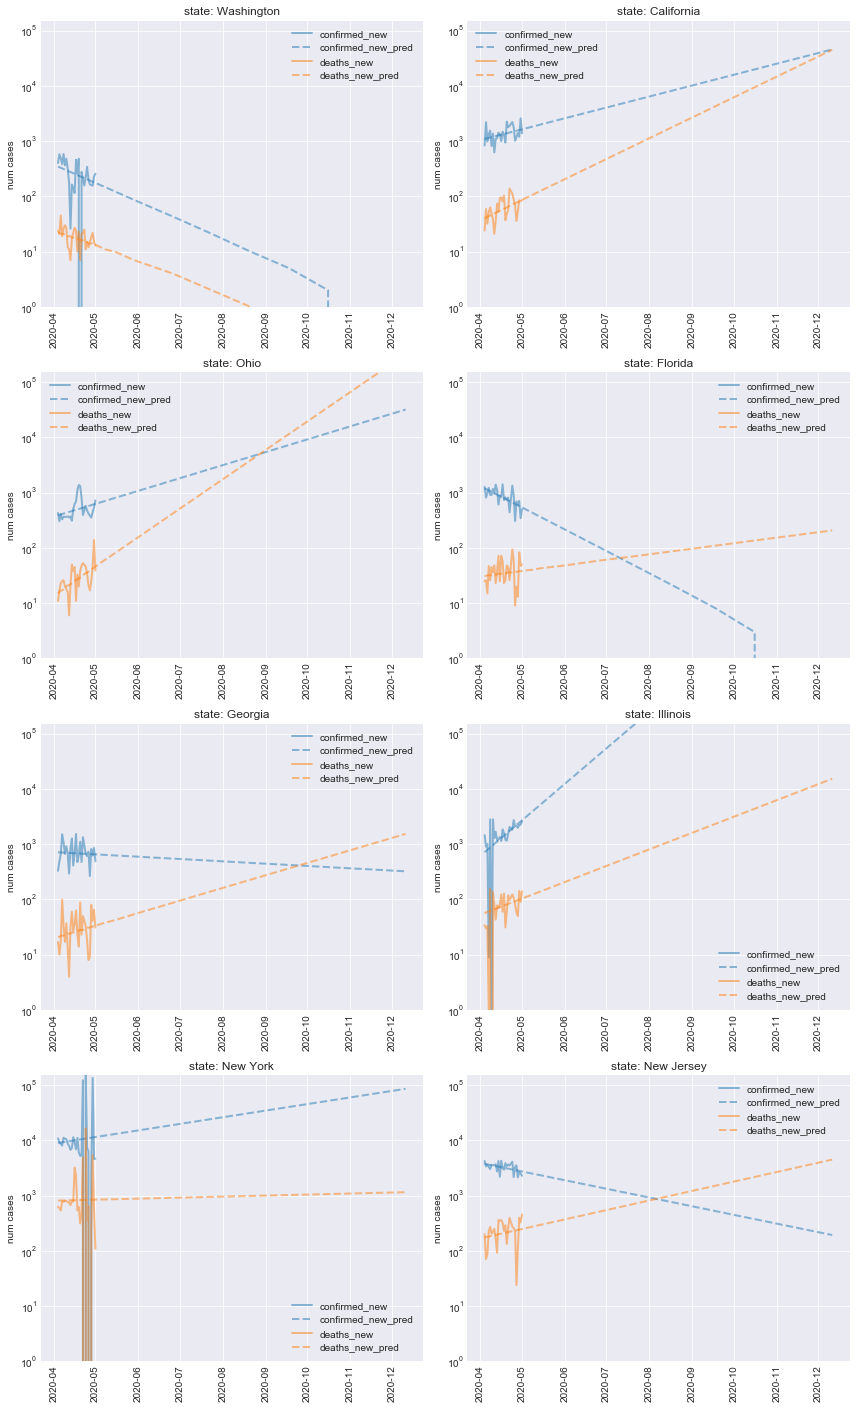

In [191]:
plot_forecasts_new(dfp_us_recent_1, col_locale='state', top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey'])

In [192]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-05-01_n_days_training=28.csv
